In [1]:
# Original imports from metroscore notebook
from typing import Tuple, List
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import contextily as cx

import networkx as nx
import osmnx as ox

import metroscore.network_builder as mnb
import metroscore.service_areas as msa
import metroscore.utils as mu

%config InlineBackend.figure_format = 'retina'

In [2]:
# Additional imports that appear in the notebook body
from collections import defaultdict
from random import choice
from shapely.geometry import Point
from networkx import MultiGraph
from typing import Any, Dict, List, Optional, Set
import random

In [3]:
# Constants
DEFAULT_WALK_SPEED = 1.42 # m/s

In [4]:
mta_subway_feed = mnb.load_gtfs_feed("../data/google_transit.zip")
mta_bus_feed = mnb.load_gtfs_feed("../data/google_transit_manhattan.zip")
subway_timetable = msa.make_timetable(mta_subway_feed.stop_times)
bus_timetable = msa.make_timetable(mta_bus_feed.stop_times)
timetable = pd.concat([subway_timetable, bus_timetable])

In [5]:
# Functions in the body of metroscore notebook
def get_random_edge(G):
    edge = choice(list(G.edges(data=True)))
    return edge

def load_network_and_timetable(metro=mta_subway_feed, bus=mta_bus_feed, **kwargs):
    transit_graph = None
    timetable = None
    for mode, feed in ({"metro": metro, "bus": bus} | kwargs).items():
        print(f"Importing {mode} data...")
        if mode == 'walk':
            G = feed
        else:
            node_gdf, edge_gdf, mapping = mnb.build_edge_and_node_gdf(feed)
            print(f"{mode}: \t{node_gdf.shape[0]} nodes \t{edge_gdf.shape[0]} edges")
            G = ox.graph_from_gdfs(node_gdf, edge_gdf)
            _timetable = msa.make_timetable(
                feed.stop_times.assign(
                    stop_id=feed.stop_times['stop_id'].map(lambda x: mapping.get(x, x))
                )
            )
            timetable = pd.concat([timetable, _timetable])
        G = ox.project_graph(G, to_latlong=True)

        # append to transit_graph
        transit_graph = mu.merge_graphs(a=transit_graph, other=G)
    return transit_graph, timetable

def plot_graph_interactive(graph):
    m = ox.graph_to_gdfs(graph, nodes=False, edges=True).explore(name="Routes")
    m = ox.graph_to_gdfs(graph, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")
    folium.LayerControl().add_to(m)   
    return m

def get_closest_node(start_points: List[Tuple[float, float]], graph) -> Tuple[int, float]:
    """Get closest node to graph and how long it'll take to get there, in seconds."""
    point_gdf = gpd.GeoDataFrame([(*point, Point(*point)) for point in start_points], geometry=2, crs=4326).to_crs(3857)
    if graph.graph.get('crs') != 3857:
        # need the graph in a projected CRS. Use 3857 for consistency with starting point CRS
        graph = ox.project_graph(graph, to_crs=3857)
    nodes_and_dists = list(zip(*ox.nearest_nodes(G=graph, X=point_gdf.loc[:, 2].x, Y=point_gdf.loc[:, 2].y, return_dist=True)))
    # convert dists into walk time
    return list(map(lambda x: (x[0], x[1] / DEFAULT_WALK_SPEED), nodes_and_dists))

In [6]:
def time_dependent_dijkstra(
    G: MultiGraph,
    timetable: pd.Series,
    start_time: float,
    origin_id: Any,
) -> Dict[int, float]:
    """
    Implements a modified Djikstra algorithm that finds the time-dependent shortest path from
    origin node to all other nodes in the graph.

    Args:
        G (Graph): NetworkX Graph object.
        stop_times (pd.Series): Departure times. Index is a tuple of (from, to)
            node IDs. Values are in seconds (since midnight.)
        start_time (float): Current time.
        origin_id (Any): Origin node ID.

    Returns:
        Dict[int, float]: Dictionary of node IDs and arrival times, in seconds.

    Based on algorithm outlined in Stephen Boyles' lecture:
    https://sboyles.github.io/teaching/ce392d/8-tdsp.pdf
    """
    # Initialization step
    N = len(G.nodes)
    L = {_id: np.inf for _id in G.nodes}  # travel time from origin to node
    q = {_id: -1 for _id in G.nodes}  # q is the predecessor node
    F: Set[int] = set()  # set of settled nodes

    L[origin_id] = start_time

    while len(F) < N:
        curr_id = min(((x, y) for x, y in L.items() if x not in F), key=lambda x: x[1])[
            0
        ]
        curr_time = L[curr_id]
        F.add(curr_id)
        for candidate_id in G.neighbors(curr_id):
            if candidate_id in F:
                continue
            # wait time is next departure time - current time in day
            wait_time = get_next_departure_time(
                curr_time,
                curr_id,
                candidate_id,
                timetable,
            ) - (curr_time % 86400)
            try:
                travel_time = G.get_edge_data(curr_id, candidate_id)["travel_time"]
            except KeyError:
                travel_time = G.get_edge_data(curr_id, candidate_id, key=0)[
                    "travel_time"
                ]
            if L[candidate_id] > curr_time + travel_time + wait_time:
                L[candidate_id] = curr_time + travel_time + wait_time
                q[candidate_id] = curr_id

    return L

def get_next_departure_time(
    curr_time: float,
    origin_id: int,
    dest_id: int,
    timetable: pd.Series,
):
    """
    Get the departure time from origin node to destination node.
    """
    daily_curr_time = curr_time % 86000
    # binary insert the current time into the timetable for origin to destination
    if (origin_id, dest_id) not in timetable.index:
        return curr_time  # no timetable for this route, assume no wait time
    timetable_for_route = timetable.loc[(origin_id, dest_id)]
    next_departure_time_idx = np.searchsorted(
        timetable_for_route,
        daily_curr_time,
        side="left",
    )
    if next_departure_time_idx == len(timetable_for_route):
        return timetable_for_route[0]  # wrap around if we miss last transit of day
    return timetable_for_route[next_departure_time_idx]


In [7]:
walk_network = ox.load_graphml("nyc_walk.graphml")

In [8]:
point = (-73.9964627696242, 40.72953173621136) # Coordinates for NYU WSP Campus 
PLACE = "New York City, NY, USA"

drive_network = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='drive'
)
drive_network = ox.project_graph(drive_network)

s = defaultdict(list)
for i, r in ox.graph_to_gdfs(drive_network, nodes=False).iterrows():
    if isinstance(r['highway'], list):
        for j, x in enumerate(r['highway']):
            if isinstance(r['maxspeed'], list):
                if str(r['maxspeed'][j]) != 'nan':
                    s[x].append(int(r['maxspeed'][j].strip("mph")))
            else:
                if str(r['maxspeed']) != 'nan':
                    s[x].append(int(r['maxspeed'].strip("mph")))
    else:
        if str(r['maxspeed']) != 'nan':
            if isinstance(r['maxspeed'], list):
                s[r['highway']].extend(map(lambda x: int(x.strip("mph")), r['maxspeed']))
            else:
                s[r['highway']].append(int(r['maxspeed'].strip("mph")))

def get_closest_node(start_points: List[Tuple[float, float]], graph) -> Tuple[int, float]:
    """Get closest node to graph and how long it'll take to get there, in seconds."""
    point_gdf = gpd.GeoDataFrame([(*point, Point(*point)) for point in start_points], geometry=2, crs=4326).to_crs(3857)
    if graph.graph.get('crs') != 3857:
        # need the graph in a projected CRS. Use 3857 for consistency with starting point CRS
        graph = ox.project_graph(graph, to_crs=3857)
    nodes_and_dists = list(zip(*ox.nearest_nodes(G=graph, X=point_gdf.loc[:, 2].x, Y=point_gdf.loc[:, 2].y, return_dist=True)))
    # convert dists into walk time
    return list(map(lambda x: (x[0], x[1] / DEFAULT_WALK_SPEED), nodes_and_dists))

drive_network = ox.add_edge_speeds(drive_network, hwy_speeds={k: np.mean(v) * 1.60934 * 0.3 for k, v in s.items()})
drive_network = ox.add_edge_travel_times(drive_network)
get_random_edge(drive_network)

(42893103,
 42847887,
 {'osmid': 216933520,
  'oneway': False,
  'highway': 'residential',
  'reversed': False,
  'length': 79.03,
  'geometry': <LINESTRING (592805.628 4511218.127, 592798.829 4511220.318, 592737.177 4511...>,
  'name': '39th Avenue',
  'speed_kph': 11.7,
  'travel_time': 24.3})

In [9]:
get_random_edge(walk_network)

(7690154508,
 7690151182,
 {'osmid': 823665363,
  'highway': 'footway',
  'oneway': False,
  'reversed': False,
  'length': 15.372,
  'geometry': <LINESTRING (584592.236 4511384.186, 584590.175 4511381.331, 584585.325 4511...>,
  'speed_kph': 5.112,
  'travel_time': 10.8})

In [10]:
transit_graph, timetable = load_network_and_timetable(walk=walk_network)

Importing metro data...


c:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


metro: 	465 nodes 	2913 edges
Importing bus data...


c:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bus: 	1455 nodes 	14916 edges


C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 101N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 103N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 104N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. 

Importing walk data...


C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 101N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 103N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 104N
  warnings.warn(
C:\Users\98245\OneDrive\文档\NYU Classes\Metroscore\metroscore-DSC-Qian\metroscore\metroscore\utils.py:99: UserWarning: Mismatched coordinates found. 

In [11]:
# Try to get a sub-section of the entire graph

# Get the closest node as the origin node

closest_node, start_time_headstart = get_closest_node(start_points=[point], graph=transit_graph)[0]

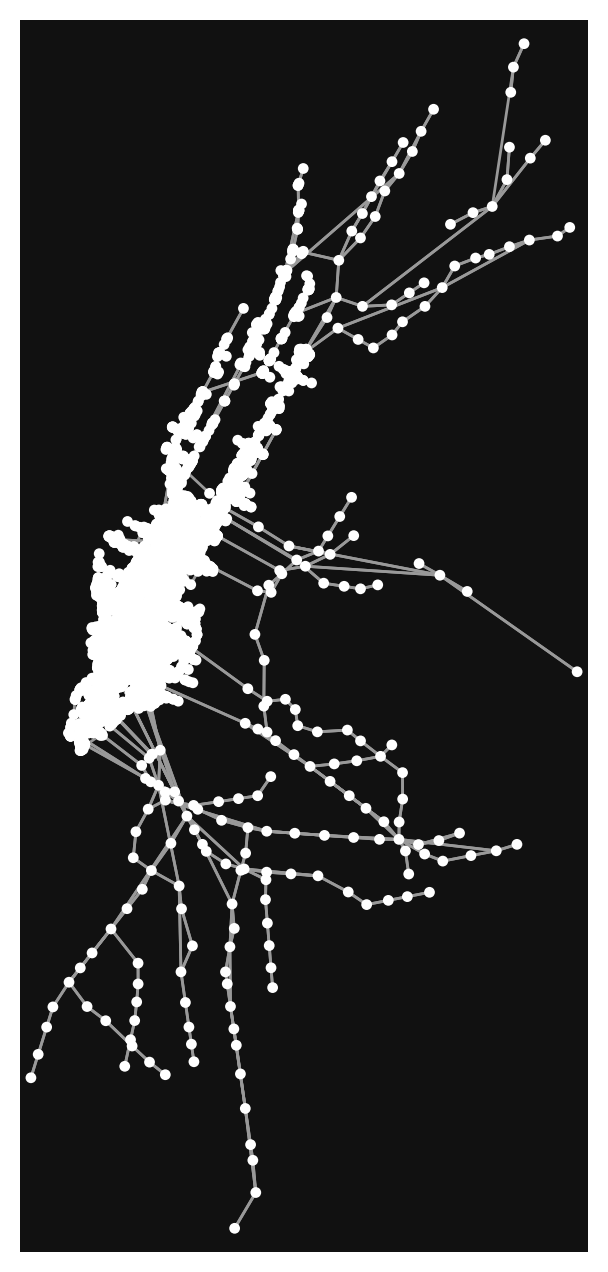

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
# Try BFS sampling for getting a connected subgraph
from collections import deque

def bfs_sample(G, origin_id, limit):

    visited = set()
    queue = deque([origin_id])
    sampled_nodes = set()

    while queue and len(sampled_nodes) < limit:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)
            sampled_nodes.add(node)
            for neighbor in G.neighbors(node):
                if neighbor not in visited:
                    queue.append(neighbor)
                    if len(sampled_nodes) >= limit:
                        break
    
    return G.subgraph(sampled_nodes).copy()

test_subgraph = bfs_sample(transit_graph, closest_node, 10000)
ox.plot_graph(test_subgraph)

In [13]:
from dateutil import parser

def start_time_to_seconds(start_time: str):
    return (parser.parse(start_time) - parser.parse("12AM")).seconds

official_start_time = start_time_to_seconds("7AM") - start_time_headstart

msa.time_dependent_dijkstra(
    G=test_subgraph,
    timetable=timetable,
    start_time=official_start_time,
    origin_id=closest_node
)

{8648032264: 25828.63242914697,
 8648032265: 25853.832429146973,
 8648032266: 25832.33242914697,
 8648032268: 25827.13242914697,
 1773076509: 26034.099999999995,
 1773076511: 25981.499999999996,
 1773076513: 25975.099999999995,
 1773076514: 25990.699999999993,
 7611187235: 26054.53242914697,
 4161568810: 26521.899999999998,
 10166304811: 26282.399999999998,
 4161568812: 26506.0,
 4161568811: 26515.3,
 4161568813: 26512.9,
 4161568815: 26519.800000000003,
 10166304812: 26298.3,
 1828749423: 26733.3,
 1828749426: 26671.999999999993,
 1828749427: 26704.09999999999,
 4149936244: 26653.3,
 4149936245: 26656.199999999997,
 7465107586: 25982.032429146966,
 7465107588: 26057.632429146965,
 '243N': 27720.0,
 10168729750: 27510.0,
 10168729755: 27516.7,
 '405227': 27574.999999999996,
 8279851176: 27174.9,
 8279851177: 27142.0,
 8279851179: 27227.8,
 8279851186: 27149.0,
 8279851187: 27149.4,
 8279851193: 26467.400000000005,
 8279851197: 26916.0,
 '401670': 27881.0,
 8279851227: 26501.6,
 8279851

In [14]:
from timeit import repeat

dijkstra_runtimes = []

for subset_nodes in range(1000, 20000, 1000):
    subgraph = bfs_sample(transit_graph, closest_node, subset_nodes)
    runtime = min(repeat('msa.time_dependent_dijkstra(G=subgraph, timetable=timetable, start_time=official_start_time, origin_id=closest_node)', globals=globals(), repeat=5, number=10)) / 5
    print(f"Runtime for subset_nodes {subset_nodes}: {runtime*1000:.2f} ms")
    dijkstra_runtimes.append(runtime)

Runtime for subset_nodes 1000: 137.85 ms
Runtime for subset_nodes 2000: 524.15 ms
Runtime for subset_nodes 3000: 1163.74 ms
Runtime for subset_nodes 4000: 2102.12 ms
Runtime for subset_nodes 5000: 3356.45 ms
Runtime for subset_nodes 6000: 4930.02 ms
Runtime for subset_nodes 7000: 6610.13 ms
Runtime for subset_nodes 8000: 8574.98 ms
Runtime for subset_nodes 9000: 10856.64 ms
Runtime for subset_nodes 10000: 13532.29 ms
Runtime for subset_nodes 11000: 16502.92 ms
Runtime for subset_nodes 12000: 19579.23 ms
Runtime for subset_nodes 13000: 23238.70 ms
Runtime for subset_nodes 14000: 27074.24 ms
Runtime for subset_nodes 15000: 31047.07 ms
Runtime for subset_nodes 16000: 35602.10 ms
Runtime for subset_nodes 17000: 40366.02 ms
Runtime for subset_nodes 18000: 45767.12 ms
Runtime for subset_nodes 19000: 50928.49 ms


Text(0.5, 1.0, 'Time-dependent Dijkstra Runtime as function of number of nodes')

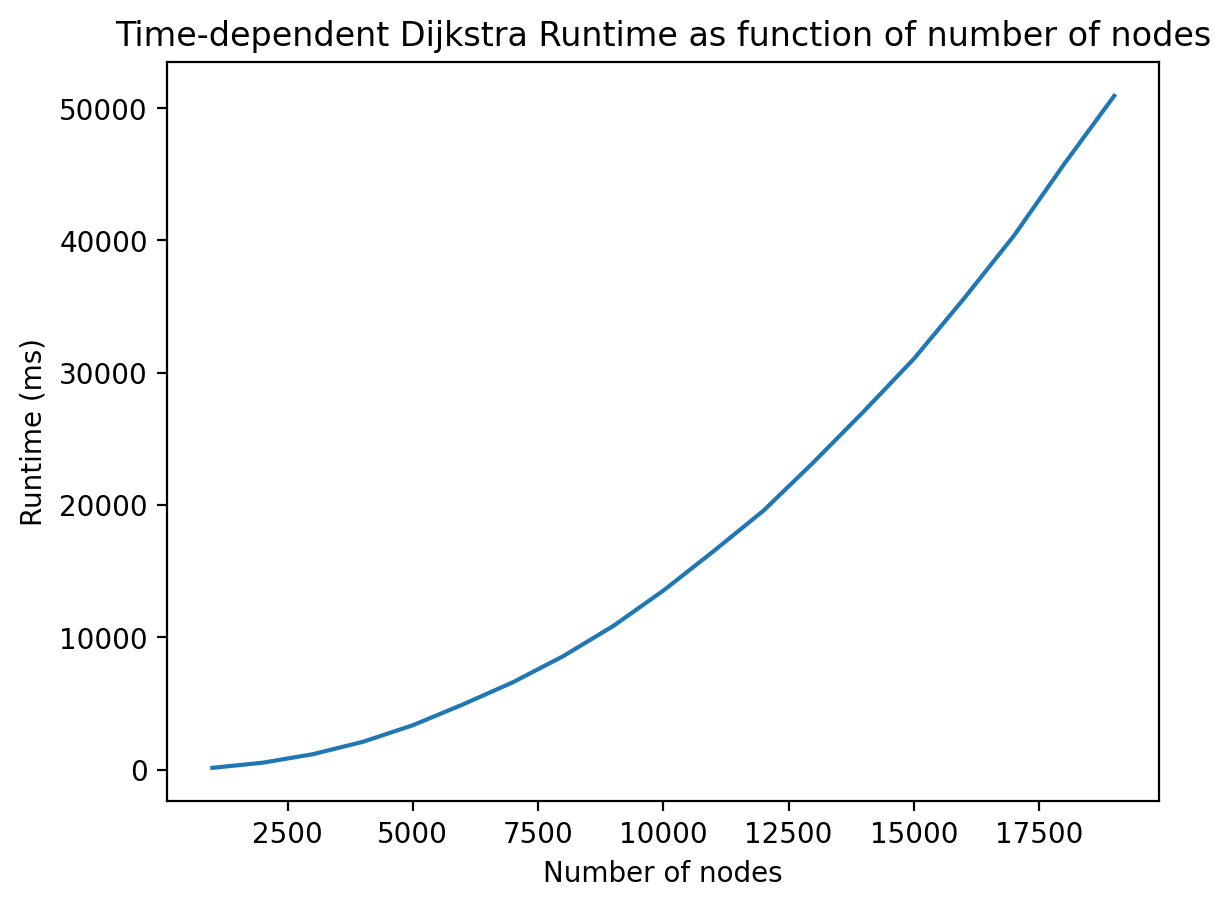

In [15]:
plt.plot(list(range(1000, 20000, 1000)), list(map(lambda x: x*1000, dijkstra_runtimes)))
plt.xlabel('Number of nodes')
plt.ylabel('Runtime (ms)')
plt.title('Time-dependent Dijkstra Runtime as function of number of nodes')

More tests: see if the patterns are consistent with other origin nodes

In [16]:
point_central_park = (-73.9653903, 40.7812589)

In [17]:
closest_node_central_park, start_time_central_park = get_closest_node(start_points=[point_central_park], graph=transit_graph)[0]

official_start_time_central_park = start_time_to_seconds("7AM") - start_time_central_park

: 

In [18]:
dijkstra_runtimes_central_park = []

for subset_nodes in range(1000, 40000, 1000):
    subgraph = bfs_sample(transit_graph, closest_node_central_park, subset_nodes)
    runtime = min(repeat('msa.time_dependent_dijkstra(G=subgraph, timetable=timetable, start_time=official_start_time_central_park, origin_id=closest_node_central_park)', globals=globals(), repeat=5, number=10)) / 5
    print(f"Runtime for subset_nodes {subset_nodes}: {runtime*1000:.2f} ms")
    dijkstra_runtimes_central_park.append(runtime)

Runtime for subset_nodes 1000: 137.55 ms
Runtime for subset_nodes 2000: 528.23 ms
Runtime for subset_nodes 3000: 1158.03 ms
Runtime for subset_nodes 4000: 2083.71 ms
Runtime for subset_nodes 5000: 3268.24 ms
Runtime for subset_nodes 6000: 4751.82 ms
Runtime for subset_nodes 7000: 6459.24 ms
Runtime for subset_nodes 8000: 8454.74 ms
Runtime for subset_nodes 9000: 10932.63 ms
Runtime for subset_nodes 10000: 13790.08 ms
Runtime for subset_nodes 11000: 16487.94 ms
Runtime for subset_nodes 12000: 19605.34 ms
Runtime for subset_nodes 13000: 23183.47 ms
Runtime for subset_nodes 14000: 26978.73 ms
Runtime for subset_nodes 15000: 31216.65 ms
Runtime for subset_nodes 16000: 35813.06 ms
Runtime for subset_nodes 17000: 40743.28 ms
Runtime for subset_nodes 18000: 45979.99 ms
Runtime for subset_nodes 19000: 51411.45 ms
Runtime for subset_nodes 20000: 55916.07 ms
Runtime for subset_nodes 21000: 61614.10 ms
Runtime for subset_nodes 22000: 67304.42 ms


In [1]:
plt.plot(list(range(1000, 10000, 1000)), list(map(lambda x: x*1000, dijkstra_runtimes_central_park)))
plt.xlabel('Number of nodes')
plt.ylabel('Runtime (ms)')
plt.title('Time-dependent Dijkstra Runtime as function of number of nodes')

NameError: name 'plt' is not defined